In [1]:
!git clone --branch inference-tf-2.x https://github.com/steubk/White-box-Cartoonization.git
!pip install --upgrade tf_slim

Cloning into 'White-box-Cartoonization'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 63.41 MiB | 26.37 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 6.6 MB/s eta 0:00:00


In [2]:
import sys

sys.path.append("./White-box-Cartoonization/test_code")

import cartoonize
import os

import network
import guided_filter

In [3]:
# We will be using TensorFlow session
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()

In [4]:
!mkdir saved_model_dir

In [5]:
tf.reset_default_graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

model_path = "./White-box-Cartoonization/test_code/saved_models"

with tf.Session(config=config) as sess:
    # Create placeholder for the input
    input_photo = tf.placeholder(tf.float32, [1, None, None, 3], name="input_photo")

    # Run the input placeholder through the generator, and then apply a
    # filter to process the generator output
    network_out = network.unet_generator(input_photo)
    final_out = guided_filter.guided_filter(input_photo, network_out, r=1, eps=5e-3)
    final_out = tf.identity(
        final_out, name="final_output"
    )  # Create an identical filtering layer

    # The above process is basically needed to construct the computation graph for the
    # current session

    # Get the generator variables and restore the pre-trained checkpoints in the
    # current session
    all_vars = tf.trainable_variables()
    gene_vars = [var for var in all_vars if "generator" in var.name]
    saver = tf.train.Saver(var_list=gene_vars)
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint(model_path))

    # Export to SavedModel
    tf.saved_model.simple_save(
        sess,
        "/content/saved_model_dir",
        inputs={input_photo.name: input_photo},
        outputs={final_out.name: final_out},
    )

/usr/local/lib/python3.9/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Restart runtime.

In [1]:
import tensorflow as tf 

root = tf.saved_model.load("/content/saved_model_dir")
concrete_func = root.signatures["serving_default"]

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def resize_crop(image):
    h, w, c = np.shape(image)
    if min(h, w) > 720:
        if h > w:
            h, w = int(720 * h / w), 720
        else:
            h, w = 720, int(720 * w / h)
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
    h, w = (h // 8) * 8, (w // 8) * 8
    image = image[:h, :w, :]
    return image

In [4]:
!wget -O image.jpg https://raw.githubusercontent.com/sayakpaul/portfolio/master/images/image_sayak.jpg

--2023-03-17 03:19:51--  https://raw.githubusercontent.com/sayakpaul/portfolio/master/images/image_sayak.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111191 (109K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 108.58K  --.-KB/s    in 0.02s   

2023-03-17 03:19:52 (4.47 MB/s) - ‘image.jpg’ saved [111191/111191]



In [5]:
# Prepare image for inference
image = cv2.imread("image.jpg")
image = resize_crop(image)
image = image.astype(np.float32) / 127.5 - 1
image = np.expand_dims(image, axis=0)
image.shape

(1, 440, 288, 3)

In [7]:
result = concrete_func(tf.constant(image.astype("float32")))

In [11]:
result["final_output:0"].shape

TensorShape([1, 440, 288, 3])

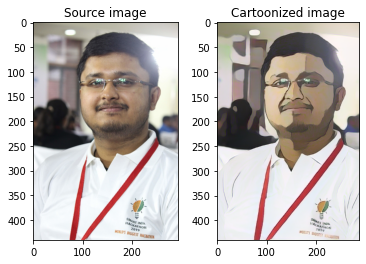

In [12]:
output = (np.squeeze(result["final_output:0"][0].numpy()) + 1.0) * 127.5
output = np.clip(output, 0, 255).astype(np.uint8)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(plt.imread("image.jpg"))
plt.title("Source image")
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title("Cartoonized image")
plt.show()

In [13]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 5.3 MB/s eta 0:00:00


In [14]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

In [18]:
from huggingface_hub import HfApi

api = HfApi()
api.create_repo("sayakpaul/whitebox-cartoonizer", exist_ok=True)
api.upload_folder(folder_path="saved_model_dir", repo_id="sayakpaul/whitebox-cartoonizer")

saved_model.pb:   0%|          | 0.00/146k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/5.87M [00:00<?, ?B/s]

'https://huggingface.co/sayakpaul/whitebox-cartoonizer/tree/main/'

Reference code: https://www.kaggle.com/code/steubk/the-night-fellini-met-miyazaki